In [1]:
import numpy as np
import time
import healpy as hp
import matplotlib.pyplot as plt

import cupy as cp
import cufinufft
import finufft

import ducc0

import pysht
from pysht import get_geom

from lenspyx import cachers

import delensalot
from delensalot import utils
from delensalot.sims.sims_lib import Xunl, Xsky, Xobs


def get_toydata(lmax=1024, mmax=1024, geominfo=('gl',{'lmax': 1024})):
    ll = np.arange(0,lmax)
    # geominfo = ('gl',{'lmax': lmax})
    # geominfo = ('healpix',{'nside': 512})

    synunl = Xunl(lmax=lmax, geominfo=geominfo)
    synsky = Xsky(lmax=lmax, unl_lib=synunl, geominfo=geominfo)

    philm = synunl.get_sim_phi(0, space='alm')
    dlm = hp.almxfl(philm, np.sqrt(ll*(ll+1)))

    Tunl = synunl.get_sim_unl(0, spin=0, space='alm', field='temperature')
    # Tsky = synsky.get_sim_sky(0, spin=0, space='map', field='temperature')

    return Tunl, dlm, philm
# int(t.geom.nph[0]/2-1)

def synth_gen(Tunl, solver, dlm, lmax):
    if solver in ['finufft']:
        defres, ptg, map_dfs = t.synthesis_general(Tunl.copy(), dlm=dlm, lmax=lmax, mmax=lmax, spin=0, nthreads=4)
        print("defres.shape: {}".format(defres.shape))
    elif solver in ['duccnufft']:
        defres, ptg, map_dfs = t.synthesis_general(Tunl.copy(), dlm=dlm, lmax=lmax, mmax=lmax, spin=0, nthreads=4)
        print("defres.shape: {}".format(defres.shape))
    elif solver == 'ducc':
        defres = t.synthesis_general(Tunl.copy(), dlm=dlm, mmax=lmax, spin=0, backwards=False)
        print("defres.shape: {}".format(defres.shape))
    elif solver == 'cufinufft':
        defres, ptg, map_dfs = t.synthesis_general(Tunl.copy(), dlm=dlm, lmax=lmax, mmax=lmax, spin=0, nthreads=4)
        print("defres.shape: {}".format(defres.shape))
    return defres, ptg, map_dfs

mpisupport: True, pmisupport: False
disabling mpi
Using lenspyx alm2map


In [2]:
solver = 'cufinufft'
backend = 'GPU'
t = pysht.get_transformer(solver, backend)

# lmax = 2048
# mmax = 2048
# geominfo = ('gl',{'lmax': lmax})
# t.set_geometry(geominfo)
# Tunl, dlm, philm = get_toydata(lmax, mmax, geominfo)
# defres, ptg, map_dfs = synth_gen(Tunl, solver, dlm, lmax)

bm_GPU = []
for lmax in 256*np.arange(1,16):
    mmax = lmax
    geominfo = ('gl',{'lmax': lmax})
    t.set_geometry(geominfo)

    Tunl, dlm, philm = get_toydata(lmax, mmax, geominfo)
    defres, ptg, map_dfs = synth_gen(Tunl, solver, dlm, lmax)
    del t.cacher
    t.cacher = cachers.cacher_mem()
    x = cp.array(ptg[:,1])
    y = cp.array(ptg[:,0])
    data = cp.array(map_dfs.astype(np.complex128))
    result = %timeit -n 1 -r 1 -o cufinufft.nufft2d2(x=x, y=y, data=data, eps=1e-10)
    bm_GPU.append([lmax, result])
    

deflection std is 2.49e+00 amin
build angles <- synthesis (GRAD_ONLY)
build_angles
defres.shape: (257, 540)
1.62 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


In [3]:
solver = 'finufft'
backend = 'CPU'
t = pysht.get_transformer(solver, backend)

# lmax = 2048
# mmax = 2048
# geominfo = ('gl',{'lmax': lmax})
# t.set_geometry(geominfo)
# Tunl, dlm, philm = get_toydata(lmax, mmax, geominfo)
# defres, ptg, map_dfs = synth_gen(Tunl, solver, dlm, lmax)
if 'defres' in locals():
    defres = np.array(defres)
    ptg = np.array(ptg)
    map_dfs = np.array(map_dfs)
else:
    defres, ptg, map_dfs = synth_gen(solver)

bm_CPU = []
for lmax in 256*np.arange(1,16):
    mmax = lmax
    geominfo = ('gl',{'lmax': lmax})
    t.set_geometry(geominfo)

    Tunl, dlm, philm = get_toydata(lmax, mmax, geominfo)
    defres, ptg, map_dfs = synth_gen(Tunl, solver, dlm, lmax)
    del t.cacher
    t.cacher = cachers.cacher_mem()
    result = %timeit -r 1 -n 1 -o finufft.nufft2d2(x=ptg[:,0], y=ptg[:,1], f=map_dfs.astype(np.complex128), eps=1e-10)
    bm_CPU.append([lmax, result])

deflection std is 2.49e+00 amin
build angles <- synthesis (GRAD_ONLY)
build_angles
defres.shape: (257, 540)
55 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


/mnt/home/sbelkner/venv/pysht/lib/python3.10/site-packages/finufft/_interfaces.py:329: UserWarning: Argument `x` does not satisfy the following requirement: C. Copying array (this may reduce performance)
  warnings.warn(f"Argument `{name}` does not satisfy the following requirement: {prop}. Copying array (this may reduce performance)")
/mnt/home/sbelkner/venv/pysht/lib/python3.10/site-packages/finufft/_interfaces.py:329: UserWarning: Argument `y` does not satisfy the following requirement: C. Copying array (this may reduce performance)
  warnings.warn(f"Argument `{name}` does not satisfy the following requirement: {prop}. Copying array (this may reduce performance)")
/mnt/home/sbelkner/venv/pysht/lib/python3.10/site-packages/finufft/_interfaces.py:329: UserWarning: Argument `x` does not satisfy the following requirement: C. Copying array (this may reduce performance)
  warnings.warn(f"Argument `{name}` does not satisfy the following requirement: {prop}. Copying array (this may reduce p

In [4]:
solver = 'duccnufft'
backend = 'CPU'
t = pysht.get_transformer(solver, backend)

# lmax = 2048
# mmax = 2048
# geominfo = ('gl',{'lmax': lmax})
# t.set_geometry(geominfo)
# Tunl, dlm, philm = get_toydata(lmax, mmax, geominfo)
# defres, ptg, map_dfs = synth_gen(Tunl, solver, dlm, lmax)

bm_CPU_ducc = []
for lmax in 256*np.arange(1,16):
    mmax = lmax
    geominfo = ('gl',{'lmax': lmax})
    t.set_geometry(geominfo)

    Tunl, dlm, philm = get_toydata(lmax, mmax, geominfo)
    defres, ptg, map_dfs = synth_gen(Tunl, solver, dlm, lmax)
    del t.cacher
    t.cacher = cachers.cacher_mem()
    result = %timeit -n 1 -r 1 -o values = ducc0.nufft.u2nu(grid=map_dfs, coord=ptg, forward=True, epsilon=1e-10, nthreads=4, verbosity=1, periodicity=2 * np.pi, fft_order=True)
    bm_CPU_ducc.append([lmax, result])
    

deflection std is 2.49e+00 amin
build angles <- synthesis (GRAD_ONLY)
build_angles
U2nu:
  nthreads=1, grid=(526x528), oversampled grid=(840x840), supp=10, eps=1.000000000000000e-07
  npoints=138780
  memory overhead: 5.169957876205444e-04GB (index) + 1.051425933837891e-02GB (oversampled grid)
defres.shape: (138780,)

Total wall clock time for u2nu: 0.02904s
|
+- u2nu proper          : 88.19% (0.0256s)
|  |
|  +- interpolation        : 63.27% (0.0162s)
|  +- FFT                  : 28.97% (0.0074s)
|  +- zeroing grid         :  3.92% (0.0010s)
|  +- grid correction      :  3.84% (0.0010s)
|  +- allocating grid      :  0.00% (0.0000s)
|  
+- building index       :  9.34% (0.0027s)
+- correction factors   :  0.43% (0.0001s)
+- parameter calculation:  0.08% (0.0000s)
+- <unaccounted>        :  1.96% (0.0006s)
U2nu:
  nthreads=1, grid=(526x528), oversampled grid=(792x800), supp=14, eps=1.000000000000000e-10
  npoints=138780
  memory overhead: 5.169957876205444e-04GB (index) + 9.441375732421


Total wall clock time for u2nu: 0.03788s
|
+- u2nu proper          : 91.20% (0.0345s)
|  |
|  +- interpolation        : 77.58% (0.0268s)
|  +- FFT                  : 18.84% (0.0065s)
|  +- grid correction      :  2.55% (0.0009s)
|  +- zeroing grid         :  1.03% (0.0004s)
|  +- allocating grid      :  0.00% (0.0000s)
|  
+- building index       :  6.95% (0.0026s)
+- correction factors   :  0.41% (0.0002s)
+- parameter calculation:  0.05% (0.0000s)
+- <unaccounted>        :  1.40% (0.0005s)


Text(0.5, 1.0, 'nuFFT2d2 time for different lmax')

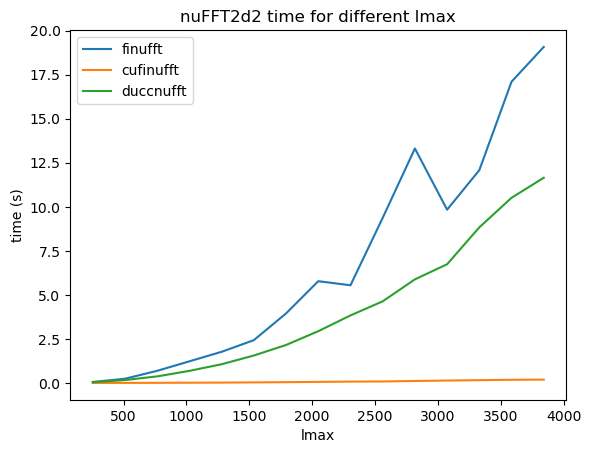

In [22]:
plt.plot([bC[0] for bC in bm_CPU], [bC[1].average for bC in bm_CPU], label='finufft')
plt.plot([bG[0] for bG in bm_GPU], [bG[1].average for bG in bm_GPU], label='cufinufft')
plt.plot([bC[0] for bC in bm_CPU_ducc], [bC[1].average for bC in bm_CPU_ducc], label='duccnufft')
plt.legend()
plt.ylabel('time (s)')
plt.xlabel('lmax')
plt.title('nuFFT2d2 time for different lmax')

Text(0.5, 1.0, 'speedup')

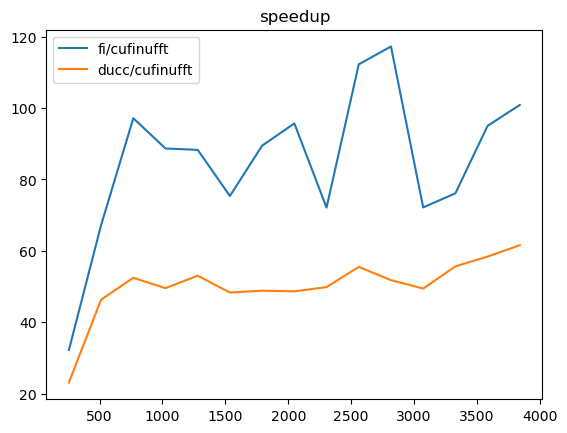

In [30]:
plt.plot([bC[0] for bC in bm_CPU], [bC[1].average/bG[1].average for bC, bG in zip(bm_CPU, bm_GPU)], label='fi/cufinufft')
plt.plot([bC[0] for bC in bm_CPU], [bC[1].average/bG[1].average for bC, bG in zip(bm_CPU_ducc, bm_GPU)], label='ducc/cufinufft')
plt.legend()
# plt.plot([bG[0] for bG in bm_GPU], [bG[1].average for bG in bm_GPU], label='cufinufft')
# plt.plot([bC[0] for bC in bm_CPU_ducc], [bC[1].average for bC in bm_CPU_ducc], label='duccnufft')
plt.title('speedup')

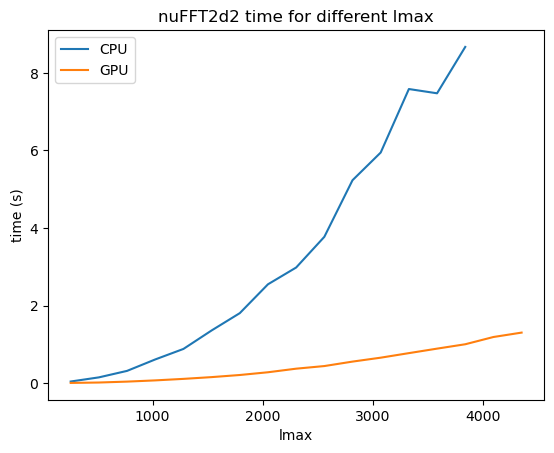